
# Đồ án môn học: Xử lý ngôn ngữ tự nhiên (CS221.O11)
## _**Đề tài**_: Xây dựng hệ thống tự động điền (autocomplete) với mô hình N-grams và Add-K Smoothing

GV Hướng dẫn: TS. Nguyễn Trọng Chỉnh

<img src="https://cdn.haitrieu.com/wp-content/uploads/2021/10/Logo-DH-Cong-Nghe-Thong-Tin-UIT.png" alt="..." width="250" />

Danh sách thành viên

| MSSV | Họ và tên |
| - | - |
|21520486| Nguyễn Đình Minh Toàn |
| 21520705 | Nguyễn Thành Đạt |
| 21520952 | Hoàng Quang Khải |


Autocomplete đề cập đến việc tự động dự đoán và hoàn thành một từ hoặc cụm từ mà người dùng cần nhập mà không cần gõ hoàn toàn. Bằng cách cung cấp những lựa chọn có sẵn để tăng tốc quá trình nhập liệu, hỗ trợ người gặp vấn đề khi nhập liệu. Tính năng tự động sửa lỗi (hoặc thay thế văn bản) hoàn thành hoặc thay thế văn bản đã được gõ trước đó. Nó có thể được sử dụng để sửa từ chứa lỗi ngữ pháp hoặc xác định từ đúng trong từ điển. Mặc dù quá trình chèn từ thường bắt đầu sau khi người dừng kết thúc việc gõ, nó vẫn là một loại dự đoán văn bản.

In [2]:
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

nltk.data.path.append('.')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name='1'></a>
## 1 - Load and Preprocess Data

<a name='1.1'></a>
### 1.1 - Load the Data

In [4]:
with open("/content/drive/MyDrive/NLP/data/en_US.twitter.txt", "r") as f:
    data = f.read()
print("Data type:", type(data))
print("Number of letters:", len(data))
print("First 300 letters of the data")
print("-------")
display(data[0:300])
print("-------")

print("Last 300 letters of the data")
print("-------")
display(data[-300:])
print("-------")


Data type: <class 'str'>
Number of letters: 3335477
First 300 letters of the data
-------


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A "

-------
Last 300 letters of the data
-------


"ust had one a few weeks back....hopefully we will be back soon! wish you the best yo\nColombia is with an 'o'...“: We now ship to 4 countries in South America (fist pump). Please welcome Columbia to the Stunner Family”\n#GutsiestMovesYouCanMake Giving a cat a bath.\nCoffee after 5 was a TERRIBLE idea.\n"

-------


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

# Đoạn văn bản trong dataset
dataset = data

# Chia các từ và đếm số lần xuất hiện của mỗi từ
words = re.findall(r'\b\w+\b', dataset.lower())  # Chuyển thành chữ thường và tìm các từ
word_counts = Counter(words)

# Lấy top 30 từ xuất hiện nhiều nhất
top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:50])

# Đảo ngược thứ tự
top_words = dict(reversed(top_words.items()))


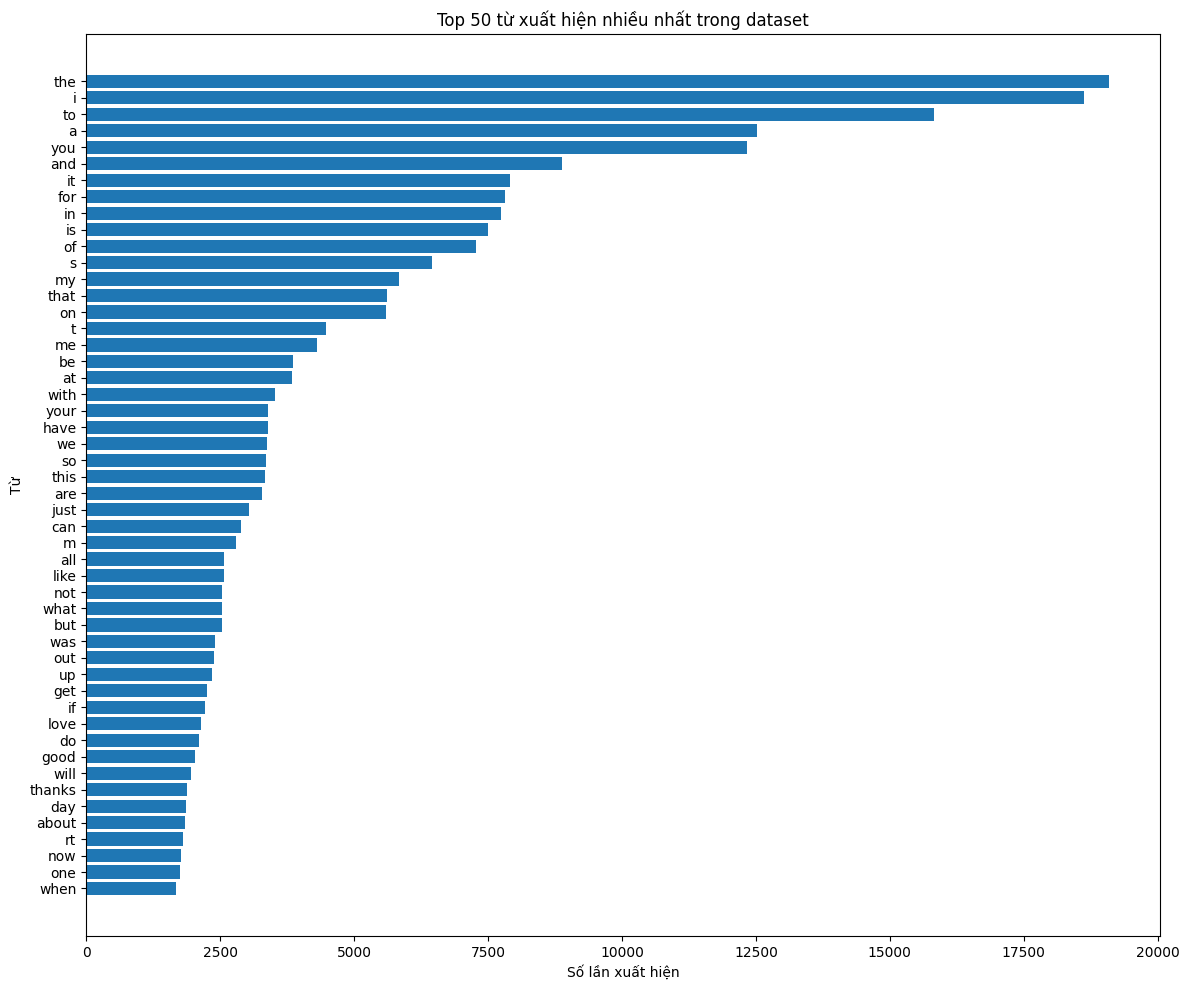

In [ ]:
# Vẽ biểu đồ thanh ngang
plt.figure(figsize=(12, 10))
plt.barh(list(top_words.keys()), list(top_words.values()))  # Lưu ý thay đổi thành barh
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Từ')
plt.title('Top 50 từ xuất hiện nhiều nhất trong dataset')
plt.tight_layout()
plt.show()

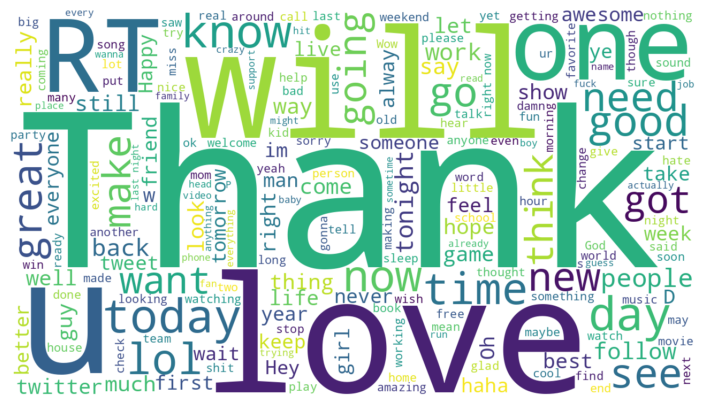

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1280, height=720, background_color='white').generate(data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

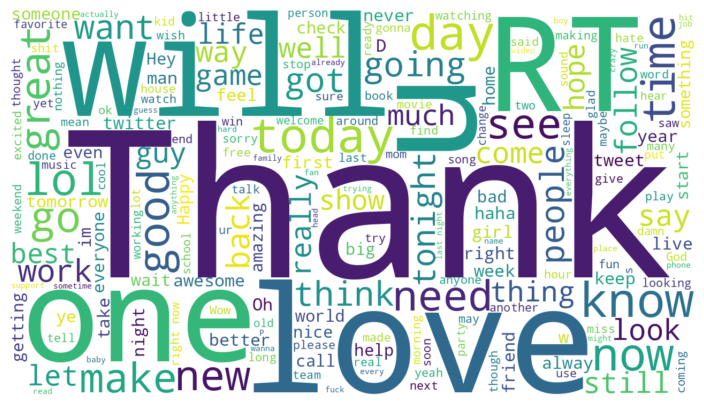

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1280, height=720, background_color='white').generate(data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

<a name='1.2'></a>
### 1.2 - Pre-processing


In [ ]:
def split_to_sentences(data):
    sentences = data.split('\n')
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    return sentences

In [ ]:
sentences = split_to_sentences(data)
sentences

['How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.',
 "When you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.",
 "they've decided its more fun if I don't.",
 'So Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)',
 'Words from a complete stranger! Made my birthday even better :)',
 'First Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!',
 'i no! i get another day off from skool due to the wonderful snow (: and THIS wakes me up...damn thing',
 "I'm coo... Jus at work hella tired r u ever in cali",
 'The new sundrop commercial ...hehe love at first sight',
 'we need to reconnect THIS WEEK',
 'I always wonder how the guys on the auctions shows learned to talk so fast!? all I hear is djsosnekspqnslanskam.',
 'Dammnnnnn what a catch',
 'such a great picture! The green shirt totally brings out your eyes!',
 'Desk put tog

In [ ]:
def tokenize_sentences(sentences):
    tokenized_sentences = []

    for sentence in sentences:
        sentence = sentence.lower()
        tokenized = nltk.word_tokenize(sentence)
        tokenized_sentences.append(tokenized)

    return tokenized_sentences

In [ ]:
tokenize_sentences(sentences[:50])

[['how',
  'are',
  'you',
  '?',
  'btw',
  'thanks',
  'for',
  'the',
  'rt',
  '.',
  'you',
  'gon',
  'na',
  'be',
  'in',
  'dc',
  'anytime',
  'soon',
  '?',
  'love',
  'to',
  'see',
  'you',
  '.',
  'been',
  'way',
  ',',
  'way',
  'too',
  'long',
  '.'],
 ['when',
  'you',
  'meet',
  'someone',
  'special',
  '...',
  'you',
  "'ll",
  'know',
  '.',
  'your',
  'heart',
  'will',
  'beat',
  'more',
  'rapidly',
  'and',
  'you',
  "'ll",
  'smile',
  'for',
  'no',
  'reason',
  '.'],
 ['they', "'ve", 'decided', 'its', 'more', 'fun', 'if', 'i', 'do', "n't", '.'],
 ['so',
  'tired',
  'd',
  ';',
  'played',
  'lazer',
  'tag',
  '&',
  'ran',
  'a',
  'lot',
  'd',
  ';',
  'ughh',
  'going',
  'to',
  'sleep',
  'like',
  'in',
  '5',
  'minutes',
  ';',
  ')'],
 ['words',
  'from',
  'a',
  'complete',
  'stranger',
  '!',
  'made',
  'my',
  'birthday',
  'even',
  'better',
  ':',
  ')'],
 ['first',
  'cubs',
  'game',
  'ever',
  '!',
  'wrigley',
  'field',
 

In [ ]:
def get_tokenized_data(data):
    sentences = split_to_sentences(data)
    tokenized_sentences = tokenize_sentences(sentences)
    return tokenized_sentences

#### Split into train and test sets

In [ ]:
tokenized_data = get_tokenized_data(data)
random.seed(87)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [ ]:
print("{} data are split into {} train and {} test set".format(
    len(tokenized_data), len(train_data), len(test_data)))

print("\nA training sample:")
print(train_data[123])

print("\nA test sample")
print(test_data[456])

47961 data are split into 38368 train and 9593 test set

A training sample:
['you', 'wear', 'white', '.', 'and', 'i', "'ll", 'ware', 'out', 'the', 'words', '``', 'i', 'love', 'you', '&', 'you', "'re", 'beautiful', '.', "''", '.']

A test sample
['#', 'heartshapedhands', 'to', 'all', 'of', 'our', 'followers', '!', 'you', 'people', 'are', 'the', 'cat', "'s", 'pajamas', '!', 'the', 'bee', "'s", 'knees', '!', '100', '%', 'awesomeness', '!', 'enjoy', 'your', 'valentine', "'s", 'day', '!']


## OOV Handling

In [ ]:
def count_words(tokenized_sentences):
    word_counts = {}

    for sentence in tokenized_sentences:
        for token in sentence:
            if token not in word_counts.keys():
                word_counts[token] = 1
            else:
                word_counts[token] += 1

    return word_counts

In [ ]:
def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
    closed_vocab = []
    word_counts = count_words(tokenized_sentences)

    for word, cnt in word_counts.items():
        if cnt >= count_threshold:
            closed_vocab.append(word)

    return closed_vocab

In [ ]:
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    vocabulary = set(vocabulary)
    replaced_tokenized_sentences = []

    for sentence in tokenized_sentences:

        replaced_sentence = []

        for token in sentence:
            if token in vocabulary:
                replaced_sentence.append(token)
            else:
                replaced_sentence.append(unknown_token)

        # Append the list of tokens to the list of lists
        replaced_tokenized_sentences.append(replaced_sentence)
    return replaced_tokenized_sentences

In [ ]:
tokenized_sentences = [["dogs", "run"], ["cats", "sleep"]]
vocabulary = ["dogs", "sleep"]
tmp_replaced_tokenized_sentences = replace_oov_words_by_unk(tokenized_sentences, vocabulary)
print(f"Original sentence:")
print(tokenized_sentences)
print(f"\ntokenized_sentences with less frequent words converted to '<unk>':")
print(tmp_replaced_tokenized_sentences)

Original sentence:
[['dogs', 'run'], ['cats', 'sleep']]

tokenized_sentences with less frequent words converted to '<unk>':
[['dogs', '<unk>'], ['<unk>', 'sleep']]


In [ ]:
def preprocess_data(train_data, test_data, count_threshold, unknown_token="<unk>", get_words_with_nplus_frequency=get_words_with_nplus_frequency, replace_oov_words_by_unk=replace_oov_words_by_unk):
    vocabulary = get_words_with_nplus_frequency(train_data,count_threshold)

    train_data_replaced = replace_oov_words_by_unk(train_data,vocabulary, unknown_token)

    test_data_replaced = replace_oov_words_by_unk(test_data,vocabulary, unknown_token)

    return train_data_replaced, test_data_replaced, vocabulary

In [ ]:
minimum_freq = 2
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data,
                                                                        test_data,
                                                                        minimum_freq)

In [ ]:
vocabulary

['i',
 'personally',
 'would',
 'like',
 'as',
 'our',
 'official',
 'glove',
 'of',
 'the',
 'team',
 'local',
 'company',
 'and',
 'quality',
 'production',
 'welcome',
 'home',
 '...',
 'happy',
 'birthday',
 'president',
 'obama',
 '!',
 'wish',
 'dvd',
 'manufacturers',
 'always',
 'use',
 'same',
 'cases',
 ',',
 'so',
 'we',
 "n't",
 'have',
 'to',
 'a',
 'dozen',
 'kinds',
 'security',
 'measures',
 '.',
 'where',
 'begin',
 "'ve",
 'been',
 'lucky',
 'really',
 'be',
 'by',
 'many',
 'wonderful',
 'teachers',
 'thats',
 'no',
 'fun',
 'baby',
 'j',
 '&',
 'at',
 'jordan',
 'ford',
 'n',
 'w/the',
 'swap',
 'your',
 'ride',
 'offer',
 'get',
 'cash',
 'super',
 'low',
 'financing',
 'affordable',
 'monthly',
 'payments',
 'party',
 'bus',
 'just',
 'came',
 'available',
 'for',
 'this',
 'friday',
 'night',
 'do',
 'miss',
 'out',
 'on',
 'cut',
 'pricing',
 'last',
 'who',
 'you',
 'rather',
 'with',
 '?',
 'chaz',
 'bono',
 'or',
 'shark',
 'thanks',
 'guys',
 'ca',
 'wait',


In [ ]:
train_data_processed[3]

['where',
 'to',
 'begin',
 '!',
 'i',
 "'ve",
 'been',
 'lucky',
 ',',
 '<unk>',
 'really',
 ',',
 'to',
 'be',
 '<unk>',
 'by',
 'so',
 'many',
 'wonderful',
 'teachers',
 '.']

In [ ]:
import numpy as np
np.save('vocabluary', vocabulary)

NameError: name 'vocabulary' is not defined

In [ ]:
print("First preprocessed training sample:")
print(train_data_processed[31210])
print()
print("First preprocessed test sample:")
print(test_data_processed[0])
print()
print("First 10 vocabulary:")
print(vocabulary[0:10])
print()
print("Size of vocabulary:", len(vocabulary))

First preprocessed training sample:
['going', 'through', '#', '<unk>', 'bag', '&', 'wondering', 'if', 'people', '*', 'actually', '*', 'pay', '$', '60', 'to', 'do', 'the', '``', 'ready', 'to', 'run', "''", '20', 'mile', 'training', 'run', '.']

First preprocessed test sample:
['that', 'picture', 'i', 'just', 'seen', 'whoa', 'dere', '!', '!', '>', '>', '>', '>', '>', '>', '>']

First 10 vocabulary:
['i', 'personally', 'would', 'like', 'as', 'our', 'official', 'glove', 'of', 'the']

Size of vocabulary: 14823



# Build n-gram based Language Models



### 1. Count n grams

In [5]:
def count_n_grams(data, n, start_token='<s>', end_token = '<e>'):

    n_grams = {}
    for sentence in data:

        # prepend start token n times, and  append the end token one time
        sentence = [start_token] * n + sentence + [end_token]

        sentence = tuple(sentence)

        for i in range(len(sentence) - n + 1):

            # Get the n-gram from i to i+n
            n_gram = tuple(sentence[i:i+n])

            # check if the n-gram is in the dictionary
            if n_gram in n_grams:

                # Increment the count for this n-gram
                n_grams[n_gram] += 1
            else:
                # Initialize this n-gram count to 1
                n_grams[n_gram] = 1

    return n_grams

In [ ]:
print("Uni-gram:")
print(count_n_grams(train_data_processed[:3], 1))
print("\nBi-gram:")
print(count_n_grams(train_data_processed[:3], 2))

Uni-gram:


NameError: name 'train_data_processed' is not defined

### 2. Estimate probability

In [7]:
def estimate_probability(word, previous_n_gram,
                         n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
    previous_n_gram = tuple(previous_n_gram)
    previous_n_gram_count = n_gram_counts.get(previous_n_gram, 0)

    denominator = previous_n_gram_count + k * vocabulary_size

    n_plus1_gram = previous_n_gram + (word,)

    n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram, 0)

    numerator = n_plus1_gram_count + k
    probability = numerator / denominator

    return probability

In [ ]:
sentences = [['i', 'want', 'a', 'new', 'phone', 'case'],
             ['i', 'need', 'two', 'new', 'tires']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
tmp_prob = estimate_probability("am", ["i"], unigram_counts, bigram_counts, len(unique_words), k=1)

print(f"The estimated probability of word 'phone' given the previous n-gram 'new' is: {tmp_prob:.4f}")

The estimated probability of word 'phone' given the previous n-gram 'new' is: 0.0909


In [8]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, end_token='<e>', unknown_token="<unk>",  k=1.0):

    previous_n_gram = tuple(previous_n_gram)

    vocabulary = vocabulary + [end_token, unknown_token]
    vocabulary_size = len(vocabulary)

    probabilities = {}
    for word in vocabulary:
        probability = estimate_probability(word, previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary_size, k=k)

        probabilities[word] = probability

    return probabilities

In [9]:
sentences = [['i', 'want', 'a', 'new', 'phone', 'case'],
             ['i', 'need', 'two', 'new', 'tires']]
unique_words = list(set(sentences[0] + sentences[1]))
unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

estimate_probabilities(["a"], unigram_counts, bigram_counts, unique_words, k=1)

{'a': 0.08333333333333333,
 'case': 0.08333333333333333,
 'phone': 0.08333333333333333,
 'want': 0.08333333333333333,
 'two': 0.08333333333333333,
 'i': 0.08333333333333333,
 'need': 0.08333333333333333,
 'new': 0.16666666666666666,
 'tires': 0.08333333333333333,
 '<e>': 0.08333333333333333,
 '<unk>': 0.08333333333333333}

In [ ]:
trigram_counts = count_n_grams(sentences, 3)
estimate_probabilities(["<s>", "<s>"], bigram_counts, trigram_counts, unique_words, k=1)

{'want': 0.07692307692307693,
 'a': 0.07692307692307693,
 'new': 0.07692307692307693,
 'i': 0.23076923076923078,
 'case': 0.07692307692307693,
 'need': 0.07692307692307693,
 'tires': 0.07692307692307693,
 'two': 0.07692307692307693,
 'phone': 0.07692307692307693,
 '<e>': 0.07692307692307693,
 '<unk>': 0.07692307692307693}

#### Count and probability matrices


In [1]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):

    vocabulary = vocabulary + ["<e>", "<unk>"]
    n_grams = []
    for n_plus1_gram in n_plus1_gram_counts.keys():
        n_gram = n_plus1_gram[0:-1]
        n_grams.append(n_gram)
    n_grams = list(set(n_grams))

    # mapping from n-gram to row
    row_index = {n_gram:i for i, n_gram in enumerate(n_grams)}
    # mapping from next word to column
    col_index = {word:j for j, word in enumerate(vocabulary)}

    nrow = len(n_grams)
    ncol = len(vocabulary)
    count_matrix = np.zeros((nrow, ncol))
    for n_plus1_gram, count in n_plus1_gram_counts.items():
        n_gram = n_plus1_gram[0:-1]
        word = n_plus1_gram[-1]
        if word not in vocabulary:
            continue
        i = row_index[n_gram]
        j = col_index[word]
        count_matrix[i, j] = count

    count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=vocabulary)
    return count_matrix

In [12]:
sentences = [['i', 'want', 'a', 'new', 'phone', 'case'],
             ['i', 'need', 'two', 'new', 'tires']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 1)

print('unigram counts')
display(make_count_matrix(bigram_counts, unique_words))

unigram counts


,a,case,phone,want,two,i,need,new,tires,<e>,<unk>
(),1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0


In [10]:
sentences = [['i', 'want', 'a', 'new', 'phone', 'case'],
             ['i', 'need', 'two', 'new', 'tires']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)

print('bigram counts')
display(make_count_matrix(bigram_counts, unique_words))

bigram counts


,a,case,phone,want,two,i,need,new,tires,<e>,<unk>
"(a,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(new,)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(want,)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(phone,)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(i,)",0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(<s>,)",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
"(two,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(tires,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"(case,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"(need,)",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Show trigram counts
print('\ntrigram counts')
trigram_counts = count_n_grams(sentences, 3)
display(make_count_matrix(trigram_counts, unique_words))


trigram counts


,new,phone,two,a,i,case,tires,want,need,<e>,<unk>
"(a, new)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(two, new)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(want, a)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<s>, <s>)",0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<s>, i)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
"(need, two)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(i, want)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(i, need)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(new, tires)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"(new, phone)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
    count_matrix = make_count_matrix(n_plus1_gram_counts, unique_words)
    count_matrix += k
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    return prob_matrix

In [ ]:
sentences = [['i', 'want', 'a', 'new', 'phone', 'case'],
             ['i', 'need', 'two', 'new', 'tires']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)
print("bigram probabilities")
display(make_probability_matrix(bigram_counts, unique_words, k=1))

bigram probabilities


,new,phone,two,a,i,case,tires,want,need,<e>,<unk>
"(want,)",0.083333,0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(i,)",0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.153846,0.153846,0.076923,0.076923
"(<s>,)",0.076923,0.076923,0.076923,0.076923,0.230769,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923
"(need,)",0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(two,)",0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(tires,)",0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333
"(new,)",0.076923,0.153846,0.076923,0.076923,0.076923,0.076923,0.153846,0.076923,0.076923,0.076923,0.076923
"(phone,)",0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333
"(case,)",0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333
"(a,)",0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333


In [ ]:
print("trigram probabilities")
trigram_counts = count_n_grams(sentences, 3)
display(make_probability_matrix(trigram_counts, unique_words, k=1))

trigram probabilities


,new,phone,two,a,i,case,tires,want,need,<e>,<unk>
"(a, new)",0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(two, new)",0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333
"(want, a)",0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(<s>, <s>)",0.076923,0.076923,0.076923,0.076923,0.230769,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923
"(<s>, i)",0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.153846,0.153846,0.076923,0.076923
"(need, two)",0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(i, want)",0.083333,0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(i, need)",0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
"(new, tires)",0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333
"(new, phone)",0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333



## Perplexity


In [ ]:
def calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, start_token='<s>', end_token = '<e>', k=1.0):
    # length of previous words
    n = len(list(n_gram_counts.keys())[0])

    # prepend <s> and append <e>
    sentence = [start_token] * n + sentence + [end_token]

    # Cast the sentence from a list to a tuple
    sentence = tuple(sentence)

    # length of sentence (after adding <s> and <e> tokens)
    N = len(sentence)

    # The variable p will hold the product
    # that is calculated inside the n-root
    # Update this in the code below
    product_pi = 1.0


    for t in range(n, N):

        # get the n-gram preceding the word at position t
        n_gram = sentence[t - n:t]

        # get the word at position t
        word = sentence[t]

        # Estimate the probability of the word given the n-gram
        # using the n-gram counts, n-plus1-gram counts,
        # vocabulary size, and smoothing constant
        probability = estimate_probability(word, n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k)

        # Update the product of the probabilities
        # This 'product_pi' is a cumulative product
        # of the (1/P) factors that are calculated in the loop
        product_pi *= 1 / probability


    # Take the Nth root of the product
    perplexity = (product_pi)**(1/N)

    return perplexity

In [ ]:
def calculate_perplexity_for_corpus(corpus, n_gram_counts, n_plus1_gram_counts, vocabulary_size, start_token='<s>', end_token='<e>', k=1.0):
    total_words = 0
    total_log_probability = 0.0

    for sentence in corpus:
        perplexity = calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, start_token, end_token, k)

        # Update total log probability and total words
        total_log_probability += perplexity
        total_words += len(sentence)

    # Calculate the overall perplexity for the entire corpus
    corpus_perplexity = total_log_probability / total_words

    return corpus_perplexity

# Example usage:
# perplexity_for_corpus = calculate_perplexity_for_corpus(corpus, n_gram_counts, n_plus1_gram_counts, vocabulary_size)


In [ ]:
# test your code

sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)


perplexity_train1 = calculate_perplexity(sentences[0],
                                         unigram_counts, bigram_counts,
                                         len(unique_words), k=1.0)
print(f"Perplexity for first train sample: {perplexity_train1:.4f}")

test_sentence = ['i', 'like', 'a', 'dog']
perplexity_test = calculate_perplexity(test_sentence,
                                       unigram_counts, bigram_counts,
                                       len(unique_words), k=1.0)
print(f"Perplexity for test sample: {perplexity_test:.4f}")

Perplexity for first train sample: 2.8040
Perplexity for test sample: 3.9654


In [ ]:
unigram_counts = count_n_grams(train_data_processed, 1)
bigram_counts = count_n_grams(train_data_processed, 2)
trigram_counts = count_n_grams(train_data_processed, 3)
fourgram_counts = count_n_grams(train_data_processed, 4)
fivegram_counts = count_n_grams(train_data_processed, 5)

In [ ]:
fivegram_counts

{('<s>', '<s>', '<s>', '<s>', '<s>'): 38368,
 ('<s>', '<s>', '<s>', '<s>', 'i'): 4156,
 ('<s>', '<s>', '<s>', 'i', 'personally'): 1,
 ('<s>', '<s>', 'i', 'personally', 'would'): 1,
 ('<s>', 'i', 'personally', 'would', 'like'): 1,
 ('i', 'personally', 'would', 'like', 'as'): 1,
 ('personally', 'would', 'like', 'as', 'our'): 1,
 ('would', 'like', 'as', 'our', 'official'): 1,
 ('like', 'as', 'our', 'official', 'glove'): 1,
 ('as', 'our', 'official', 'glove', 'of'): 1,
 ('our', 'official', 'glove', 'of', 'the'): 1,
 ('official', 'glove', 'of', 'the', 'team'): 1,
 ('glove', 'of', 'the', 'team', 'local'): 1,
 ('of', 'the', 'team', 'local', 'company'): 1,
 ('the', 'team', 'local', 'company', 'and'): 1,
 ('team', 'local', 'company', 'and', 'quality'): 1,
 ('local', 'company', 'and', 'quality', 'production'): 1,
 ('company', 'and', 'quality', 'production', '<e>'): 1,
 ('<s>', '<s>', '<s>', '<s>', 'welcome'): 57,
 ('<s>', '<s>', '<s>', 'welcome', 'home'): 4,
 ('<s>', '<s>', 'welcome', 'home', '.

In [ ]:
x = train_data_processed[15]
x

['you', 'are', 'amazing', 'samuel', '<', '3']

In [ ]:
perplexity_for_corpus = calculate_perplexity(x, unigram_counts, bigram_counts, len(vocabulary))
perplexity_for_corpus

170.6460043773214

In [ ]:
perplexity_for_corpus = calculate_perplexity(x, bigram_counts, trigram_counts, len(vocabulary))
perplexity_for_corpus

209.09072944709953

In [ ]:
perplexity_for_corpus = calculate_perplexity(x, trigram_counts, fourgram_counts, len(vocabulary))
perplexity_for_corpus

221.36654470592384

In [ ]:
perplexity_for_corpus = calculate_perplexity(x, fourgram_counts, fivegram_counts, len(vocabulary))
perplexity_for_corpus

135.49148362171002

<a name='4'></a>
## 4 - Build an Auto-complete System

In this section, you will combine the language models developed so far to implement an auto-complete system.


In [ ]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, end_token='<e>', unknown_token="<unk>", k=1.0, start_with=None):
    # length of previous words
    n = len(list(n_gram_counts.keys())[0])

    # append "start token" on "previous_tokens"
    previous_tokens = ['<s>'] * n + previous_tokens

    # From the words that the user already typed
    # get the most recent 'n' words as the previous n-gram
    previous_n_gram = previous_tokens[-n:]

    probabilities = estimate_probabilities(previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary, k=k)

    # Initialize suggested word to None
    # This will be set to the word with highest probability
    suggestion = None

    # Initialize the highest word probability to 0
    # this will be set to the highest probability
    # of all words to be suggested
    max_prob = 0


    # For each word and its probability in the probabilities dictionary:
    for word, prob in probabilities.items():  # complete this line

        # If the optional start_with string is set
        if start_with is not None:  # complete this line with the proper condition

            # Check if the beginning of the word does not match with the letters in 'start_with'
            if not word.startswith(start_with):  # complete this line with the proper condition

                # if they don't match, skip this word (move onto the next word)
                continue

        # Check if this word's probability
        # is greater than the current maximum probability
        if prob > max_prob:  # complete this line with the proper condition

            # If so, save this word as the best suggestion (so far)
            suggestion = word

            # Save the new maximum probability
            max_prob = prob


    return suggestion, max_prob

#### Get multiple suggestions

The function defined below loop over varioud n-gram models to get multiple suggestions.

In [ ]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
    model_counts = len(n_gram_counts_list)
    suggestions = []
    for i in range(model_counts-1):
        n_gram_counts = n_gram_counts_list[i]
        n_plus1_gram_counts = n_gram_counts_list[i+1]

        suggestion = suggest_a_word(previous_tokens, n_gram_counts,
                                    n_plus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
        suggestions.append(suggestion)
    return suggestions

#### Suggest multiple words using n-grams of varying length

In [ ]:
n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = count_n_grams(train_data_processed, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


In [ ]:
import numpy as np
np.save('ngrams', n_gram_counts_list)
test = np.load('ngrams.npy', allow_pickle=True)
type(test)

numpy.ndarray

In [ ]:
previous_tokens = ["i", "love"]
tmp_suggest4 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest4)

The previous words are ['i', 'love'], the suggestions are:


[('you', 0.0147005444646098),
 ('you', 0.008967444278380662),
 ('you', 0.0026597513132522108),
 ('you', 0.0026597513132522108)]

In [ ]:
previous_tokens = ["enjoy", "the"]
tmp_suggest5 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest5)

The previous words are ['enjoy', 'the'], the suggestions are:


[('<unk>', 0.037023496959021567),
 ('games', 0.00026926960619320093),
 ('little', 0.00013488905375328792),
 ('little', 0.00013488905375328792),
 ('little', 0.00013488905375328792),
 ('little', 0.00013488905375328792)]

In [ ]:
previous_tokens = ["thanks"]
tmp_suggest6 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest6)

The previous words are ['thanks'], the suggestions are:


[('for', 0.042676953220671075),
 ('for', 0.02748899802283309),
 ('for', 0.02748899802283309),
 ('for', 0.02748899802283309),
 ('for', 0.02748899802283309),
 ('for', 0.02748899802283309)]

In [ ]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest7 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest7)

NameError: name 'get_suggestions' is not defined

In [ ]:
previous_tokens = ["hey", "how", "are", "you",]
tmp_suggest8 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with="")

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest8)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are:


[('do', 0.00901999024865919),
 ('doing', 0.0016409583196586807),
 ('doing', 0.0004705249714324124),
 ('dvd', 6.744907594765952e-05)]